In [1]:
# Load the dataset
import pandas as pd
train_numerical = pd.read_pickle("features_v3.pkl") # only numerical

In [2]:
# Import used libraries
from imblearn.over_sampling import SMOTE # solving imbalanced dataset
from sklearn.model_selection import train_test_split

import xgboost as xgb # model
from xgboost import XGBClassifier # model

# evaluation metrics
from sklearn import metrics
from sklearn.metrics import fbeta_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

# parametar tuning
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt

In [3]:
# XGBoost with specific parameters and cross validation
def modelfit(alg, X, y, cv_folds=5, early_stopping_rounds=40):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X.values, label=y.values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,metrics='auc', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])
    
    # Fit
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)
    alg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
    
    # Predict
    y_pred = alg.predict(X_test)
        
    # Print model report:
    print("MCC : %.4g" % matthews_corrcoef(y_test, y_pred))
    print("AUC Score: %f" % metrics.roc_auc_score(y_test, y_pred))
    
    return alg, y_pred

In [3]:
# Test Data: Uning only numerical + date

# Merge all features into one dataset
train_date = pd.read_pickle("train_date_features.pkl")
train_features = pd.merge(train_date, train_numerical)
train_features.columns = train_features.columns.astype(str)

# Include all faults
df = train_features
# Replace nulls with mean
df = df.fillna(df.mean())
X = df[0:1000000].drop(columns=['Id', 'Response'])
y = df[0:1000000]['Response']
print(len(X), len(y))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
print(len(X), len(y))
test = df[1000000:]
X_test = test.drop(columns=['Id', 'Response'])
y_test = test['Response']

1000000 1000000
1988344 1988344


In [5]:
# Fit XGBoost on full train data
model = XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=5,min_child_weight=5,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1)
alg, y_pred = modelfit(model, X, y)

[0]	validation_0-logloss:0.65498	validation_1-logloss:0.65510
[1]	validation_0-logloss:0.62429	validation_1-logloss:0.62441
[2]	validation_0-logloss:0.59803	validation_1-logloss:0.59827
[3]	validation_0-logloss:0.58205	validation_1-logloss:0.58233
[4]	validation_0-logloss:0.55896	validation_1-logloss:0.55925
[5]	validation_0-logloss:0.53806	validation_1-logloss:0.53837
[6]	validation_0-logloss:0.51631	validation_1-logloss:0.51663
[7]	validation_0-logloss:0.50017	validation_1-logloss:0.50050
[8]	validation_0-logloss:0.48631	validation_1-logloss:0.48665
[9]	validation_0-logloss:0.47281	validation_1-logloss:0.47321
[10]	validation_0-logloss:0.45596	validation_1-logloss:0.45630
[11]	validation_0-logloss:0.43792	validation_1-logloss:0.43821
[12]	validation_0-logloss:0.42276	validation_1-logloss:0.42302
[13]	validation_0-logloss:0.41131	validation_1-logloss:0.41153
[14]	validation_0-logloss:0.39819	validation_1-logloss:0.39839
[15]	validation_0-logloss:0.38877	validation_1-logloss:0.38893
[1

In [11]:
# Test Data 3: Uning only numerical + date + normalized date
# Merge all features into one final dataset
import pandas as pd
from sklearn import preprocessing

train_date = pd.read_pickle("train_date_features.pkl")
# Standardize date
train_date = train_date.fillna(train_date.mean())
for column in train_date.columns:
    if column == 'Id': continue
    train_date[column] = (train_date[column] - train_date[column].mean()) / train_date[column].std()
train_features = pd.merge(train_date, train_numerical)
train_features.columns = train_features.columns.astype(str)

# Include all faults
faults = train_features[train_features['Response']==1]
df = train_features.sample(n = 200000)
df = pd.concat([faults,df])
# Replace nulls with mean
df = df.fillna(df.mean())
X = df[0:100000].drop(columns=['Id', 'Response'])
y = df[0:100000]['Response']
print(len(X), len(y))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
print(len(X), len(y))
test = df[100000:150000]
X_test = test.drop(columns=['Id', 'Response'])
y_test = test['Response']

100000 100000
185144 185144


In [13]:
# Fit XGBoost
model = XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=5,min_child_weight=5,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1)
alg, y_pred = modelfit(model, X, y)

[0]	validation_0-logloss:0.66553	validation_1-logloss:0.66590
[1]	validation_0-logloss:0.64166	validation_1-logloss:0.64194
[2]	validation_0-logloss:0.61725	validation_1-logloss:0.61780
[3]	validation_0-logloss:0.59582	validation_1-logloss:0.59641
[4]	validation_0-logloss:0.58156	validation_1-logloss:0.58245
[5]	validation_0-logloss:0.56275	validation_1-logloss:0.56401
[6]	validation_0-logloss:0.54704	validation_1-logloss:0.54832
[7]	validation_0-logloss:0.52937	validation_1-logloss:0.53079
[8]	validation_0-logloss:0.51604	validation_1-logloss:0.51770
[9]	validation_0-logloss:0.49934	validation_1-logloss:0.50125
[10]	validation_0-logloss:0.48813	validation_1-logloss:0.49004
[11]	validation_0-logloss:0.47834	validation_1-logloss:0.48037
[12]	validation_0-logloss:0.46692	validation_1-logloss:0.46908
[13]	validation_0-logloss:0.45656	validation_1-logloss:0.45868
[14]	validation_0-logloss:0.44500	validation_1-logloss:0.44723
[15]	validation_0-logloss:0.43793	validation_1-logloss:0.44013
[1

In [ ]:
# Test Data 2: Using all features on part of the train data
# Merge all features into one final dataset
import pandas as pd
train_categorical_processed = pd.read_pickle("train_categorical_processed.pkl")
train_date = pd.read_pickle("train_date_features.pkl")
df = pd.merge(train_date, train_numerical)
train_categorical_processed['Id'] = train_numerical['Id']
train_features = pd.merge(df,train_categorical_processed)
train_features.columns = train_features.columns.astype(str)

# Include all faults
faults = train_features[train_features['Response']==1]
df = train_features.sample(n = 200000)
df = pd.concat([faults,df])
# Replace nulls with mean
df = df.fillna(df.mean())
X = df[0:100000].drop(columns=['Id', 'Response'])
y = df[0:100000]['Response']
print(len(X), len(y))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# Return back the nulls
X = X.replace(df.mean(), None)
print(len(X), len(y))
test = df[100000:150000]
# Return back the nulls
test = test.replace(df.mean(), None)
X_test = test.drop(columns=['Id', 'Response'])
y_test = test['Response']

In [5]:
# Fit XGBoost on 20% of train data
model = XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=5,min_child_weight=5,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1)
alg, y_pred = modelfit(model, X, y)

[0]	validation_0-logloss:0.65913	validation_1-logloss:0.65942
[1]	validation_0-logloss:0.63133	validation_1-logloss:0.63177
[2]	validation_0-logloss:0.61359	validation_1-logloss:0.61463
[3]	validation_0-logloss:0.59022	validation_1-logloss:0.59130
[4]	validation_0-logloss:0.57202	validation_1-logloss:0.57330
[5]	validation_0-logloss:0.56142	validation_1-logloss:0.56300
[6]	validation_0-logloss:0.54428	validation_1-logloss:0.54604
[7]	validation_0-logloss:0.52947	validation_1-logloss:0.53144
[8]	validation_0-logloss:0.51604	validation_1-logloss:0.51813
[9]	validation_0-logloss:0.50029	validation_1-logloss:0.50247
[10]	validation_0-logloss:0.48651	validation_1-logloss:0.48859
[11]	validation_0-logloss:0.47164	validation_1-logloss:0.47378
[12]	validation_0-logloss:0.46268	validation_1-logloss:0.46477
[13]	validation_0-logloss:0.45332	validation_1-logloss:0.45540
[14]	validation_0-logloss:0.44737	validation_1-logloss:0.44969
[15]	validation_0-logloss:0.43809	validation_1-logloss:0.44028
[1

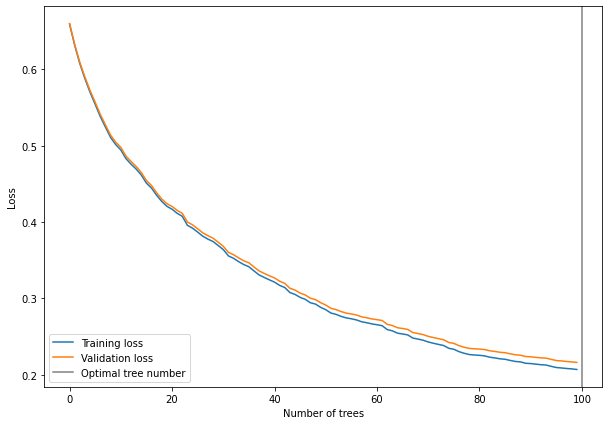

In [7]:
results = alg.evals_result()
from matplotlib import pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(alg.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [10]:
# Predict on test data

# Merge all features into one dataset
test_numerical = pd.read_pickle("test_numerical_features.pkl")
test_date = pd.read_pickle("test_date_features.pkl")
test_features = pd.merge(test_date, test_numerical)
test_features.columns = test_features.columns.astype(str)

MEAN = df.mean()
# Include all faults
df = test_features
# Replace nulls with mean
df = df.fillna(MEAN)
X_test = df.drop(columns=['Id'])
y_pred = alg.predict(X_test)

In [17]:
print(len(y_pred)) # total 1183748
len(list(filter(lambda i: i == 1, y_pred))) # predicted fault 68570, 5.7%

1183748


68570

In [8]:
# # Test 2: Using only numerical + balancing with SMOTE + train_test_split (VERY HIGH)
# df = train_numerical[0:200000]
# # Replace nulls with mean
# df = df.fillna(df.mean())
# X = df.drop(columns=['Id', 'Response'])
# y = df['Response']
# print(len(X), len(y))
# # Solve imbalanced data
# oversample = SMOTE()
# X, y = oversample.fit_resample(X, y)
# print(len(X), len(y))
# # Split training and testing dataset random
# X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=5)
# print(len(X), len(y), len(X_test), len(y_test))

In [7]:
# df = train_numerical.sample(n = 600000)
# # Replace nulls with mean
# df = df.fillna(df.mean())
# X = df[0:400000].drop(columns=['Id', 'Response'])
# y = df[0:400000]['Response']
# print(len(X), len(y))
# oversample = SMOTE()
# X, y = oversample.fit_resample(X, y)
# X = X.replace(df.mean(), None)
# print(len(X), len(y))
# test = df[400000:600000]
# X_test = test.drop(columns=['Id', 'Response'])
# y_test = test['Response']
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4, shuffle=True)

# dtrain  = xgb.DMatrix(X_train,y_train)
# dval = xgb.DMatrix(X_val, y_val)
# dtest = xgb.DMatrix(X_test, y_test)
# num_round = 65
# evallist = [ (dtrain, 'train'),(dval, 'eval')]
# param = {"nthread": 8, "max_depth" : 10, "eta":0.1, "subsample" : 0.9, "colsample_bytree" : 0.5, "objective": "binary:hinge", "booster":"gbtree"}
# bst = xgb.train(param, dtrain, num_round,evallist,early_stopping_rounds = 5)
# y_pred = bst.predict(dtest)
# f2 = fbeta_score(y_test, y_pred, beta=2)
# print(f2)
# print(matthews_corrcoef(y_test, y_pred))
# print(roc_auc_score(y_test, y_pred))

In [6]:
# Check fault predictions
filter_arr = y_test == 1
print('Total fault: ' + str(len(y_test[filter_arr])))

predictions = y_pred
total = len(predictions)
correct_fault = 0
for y_predicted, y in zip(predictions, y_test):
    if y == y_predicted == 1:
        correct_fault = correct_fault + 1
print('Total correct predicted faults: ' + str(correct_fault))

fault_counter = 0
good_count = 0
for i in predictions:
    if i == 1:
        fault_counter = fault_counter + 1
    else: 
        good_count = good_count + 1
print('Fault predicted: ' + str(fault_counter) + '; Good predicted: ' + str(good_count))

Total fault: 1051
Total correct predicted faults: 115
Fault predicted: 1743; Good predicted: 182004


In [18]:
# save
alg.save_model("model.json")

# load
# new_model = xgb.XGBRegressor()
# new_model.laod_model("my_xgboost.json")

# # check optimal number of trees of loaded model
# new_model.best_ntree_limit